# HOMEWORK 3 - What movie to watch tonight?

### Libraries

In [1]:
import pandas as pd
import heapq
import json
import csv

In [2]:
from parser_utils import clean_ls, parse_page
import utils

In [3]:
urls = json.load(open('urls.json'))
voc = json.load(open('vocabulary.json'))
inverted_index = json.load(open('inverted_index.json'))
inverted_index_freq = json.load(open('inverted_index_freq.json'))
actors_dict = json.load(open('actors_dict.json'))

# 1. Data collection

## 1.1) Get the list of movies

The first thing we had to do was to build our own dataset of movies. Each of us downloaded all the Wikipedia webpages indicated in one of the documents *movies1.html, movies2.html* and *movies3.html* that we were provided. We created to following class to parse the *html* pages and get the complete list of *urls*:

In [ ]:
class MyHTMLParser(HTMLParser):
    def handle_starttag(self, tag, attrs):
        if tag != 'a':
            return
        self.urls.append(attrs[0][1])

page = open('movies1.html').read()  # page = open('movies2.html').read() ; page = open('movies3.html').read()
parser = MyHTMLParser()
parser.urls = []
parser.feed(page)

We saved the list of *urls* in a *.json* file to easily access them is different steps of the homework.

In [ ]:
d = {}
for n, url in enumerate(parser.urls):
    d[n]=url

with open('urls.json', 'w') as fp:
    json.dump(d, fp)

## 1.2) Crawl Wikipedia

Once we we got all the *urls*, we downloaded the corresponding Wikipedia *html* webpages. Each of us did this step separetly, therefore we iterated over different ranges of indexes so that at the end we could join all the documents witout overlapping.

In [ ]:
for i in range(10000):   # range(10000,20000); range(20000,30000)
    try:
        download_page(parser.urls[i])
        time.sleep(1)
    except:
        time.sleep(1200)  # this exception happens when we reach the limit of requests of Wikipedia

The code above makes use of the function *download_page* which save the *html* page of a given *url* and which is defined as follows:

In [ ]:
def download_page(url):
    req = urllib.request.urlopen(url)
    webpage = str(req.read())
    with open("article_%d.html" %i, "w") as file:
        file.write(webpage)

## 1.3) Parse downloaded pages

In this step of the homework we parsed the downloaded pages to extract information from each of them and save the results in separate *.tsv* files structured as requested. In particular, we have selected these data:
1. **Title**: the text contained in the tag *title*  
2. **Intro**: the text contained in the first *p* tag
3. **Plot**: the text contained in the second *p* tag, when existing, otherwise *'NA'*
4. to 14. **Infobox**: when present in the parsed page a *table* tag of class *infobox vevent*, we extract the following information (if provided, otherwise *'NA'*): film_name, director, producer, writer, starring, music, release date, runtime, country, language, budget.

We used the librery **Beautiful Soup** to carry out the parsing process. For each *html* page, we first made a "soup" obtained by converting the document to Unicode, then we passed this soup our *parse_page* function and finally we save the result in a *.tsv* file.

In [ ]:
head_wiki = ['Directed by', 'Produced by', 'Written by', 'Starring', 'Music by', 'Release date', 'Running time', 'Country', 'Language', 'Budget']
head = ['title', 'intro', 'plot', 'film_name', 'director', 'producer', 'writer', 'starring', 'music', 'release date', 'runtime', 'country', 'language', 'budget']
infos = ['NA']*14

for i in range(10000):  # range(10000,20000); range(20000,30000)
    page = open('webpages/articles/article_%d.html' %i, encoding = 'utf-8').read()
    soup = BeautifulSoup(page, 'html.parser')
    infos = parse_page(soup)
    
    with open('output_%d.tsv'%i, 'w', encoding = 'utf-8') as out_file:
        tsv_writer = csv.writer(out_file, delimiter='\t')
        tsv_writer.writerow(head)
        tsv_writer.writerow(infos)

In [ ]:
def parse_page(soup):
    infos_local = infos
    infos_local[:2] = [soup.title.text, soup.find_all('p')[0].text]
    if bool(soup.findAll('table', {'class':'infobox vevent'})) == False:
        if len(soup.find_all('p'))>1:
            infos_local[2] = [soup.find_all('p')[1].text]
    else:
        infobox = soup.find_all('table', {'class':'infobox vevent'})[0].findAll('tr')
        if len(soup.find_all('p'))>1:
            infos_local[2] = [soup.find_all('p')[1].text]
        infos_local[3] =[infobox[0].text]
        
        # complete the list 'infos' with the available information
        for j in range(len(head_wiki)):
            for i in range(1,len(infobox)):
                if bool(infobox[i].find('th')):
                    if head_wiki[j] == infobox[i].th.text:
                        infos_local[j+4] = infobox[i].td.get_text(separator=', ')   # names in head_wiki correspond to those in head[4:]
                        break
    return infos_local

# 2. Search Engine

Before starting building the search engines we uesd the library **ntlk (Natural Language Toolkit)** to processes all the *.tsv* files and generate their simplified version. This step was of fundamental importance for the realization of a global vocabulary of all the (meaningful) words contained in the webpages.

During this process, we removed both stopwords and punctuation; we also reduced each word to its root form. This is the function we used:

In [ ]:
def clean_ls(list_strings):
    clean = []
    for string in list_strings:
        words = string.split()
        clean_string = ''
        for term in words:
            if not term in set(stopwords.words('english')) and term.isalnum():
                clean_string += ' '+ps.stem(term)
        if clean_string.strip() != '':
            clean.append(clean_string.strip())
    return clean

Then we applied this function to all our documents:

In [ ]:
for i in range(10000):    # range(10000,20000); range(20000,30000)
    file = open('tsv/output_%d.tsv' %i, encoding = 'ISO-8859-1') 
    lines = file.read().split('\n\n') 
    tabs = lines[1].split('\t')   # we only process the part of the tsv files with information about the movies (not the headers)
    with open('filtered_%d.tsv'%i,'a', encoding = 'utf-8')  as f:
        tsv_writer = csv.writer(f, delimiter='\t')
        tsv_writer.writerow(head) 
        tsv_writer.writerow(clean_ls(tabs))

##  2.1) Conjunctive query

Before building the indexes of our search engines, we joined the documents of the 30000 movies and create a vocabulary of the words in them, that is, a file in which each *term* is associated to an integer (*term_id*). We only focused on the words contained in the *intro* and *plot* of each document.

In [ ]:
words = set() 
for i in range(30000):
    file = open('webpages/tsv clean/filtered_%d.tsv'%i).read().split('\n\n')[1]
    tabs = file.split('\t')[1]+file.split('\t')[2]  # list of words in intro and plots
    words.update(tabs.split())

voc = dict()
for term_id, term in enumerate(words):
    voc[term]= term_id  
    
with open('vocabulary.json', 'w') as fp:
    json.dump(voc, fp)

Regardless of which search engine we decide to use to return the result of the query, there are few steps that must be executed and that are in common for all of them.

First we ask the user to enter a query:

In [4]:
print('What do you want to search?')
query = input().split() 

What do you want to search?
united states, about love


Then we "clean" the input in order to reduce it to the same format of the words in our vocabulary. For this aim we use the same functino *clean_ls* previously used:

In [5]:
query = clean_ls(query)   # list of strings
query

['unit', 'love']

At this point we extract from the vocabulary the *term_id*s of the words in the query:

In [6]:
query_index = [voc[word] for word in query]   # integers
query_index

[42573, 36605]

### 2.1.1)  Create your index!

In this step we have created the inverted index of the first search engine and stored it in a separate file. The inverted index is a vocabulary having the *term_id'*s of the words as keys and a list of the *documents_id'*s in which the corresponding term appeared as values.

In [ ]:
inverted_index = dict.fromkeys(range(len(voc)), [])
for i in range(30000):     
    file = open('webpages/tsv clean/filtered_%d.tsv'%i).read()
    lines = file.split('\n\n')[1]
    tabs = lines.split('\t')[1]+lines.split('\t')[2]  # list of words in intro and plots
    for word in set(tabs.split()):
        inverted_index[voc[word]] = inverted_index[voc[word]]+[i]

with open('inverted_index.json', 'w') as fp:
    json.dump(inverted_index, fp)   

Once we have the inverted index we can already select all the movies that match the query entered by the user:

In [9]:
allDOC = [inverted_index[str(word)] for word in query_index]
query_match = set(allDOC[0]).intersection(*allDOC[1:])   # list of integers
print(*query_match, sep=', ')

257, 1026, 388, 8837, 518, 6406, 4488, 6152, 3210, 7563, 9097, 525, 8077, 1039, 1296, 1551, 4881, 3219, 788, 8720, 1430, 2070, 1305, 2201, 4634, 5529, 5916, 7450, 8474, 2721, 5667, 170, 4016, 2097, 3890, 2739, 4144, 4915, 1206, 6838, 3768, 953, 7224, 9272, 2876, 8380, 6337, 2887, 2760, 6344, 971, 333, 3533, 335, 8526, 3794, 983, 7511, 9354, 1883, 4315, 606, 9823, 7423, 9060, 2919, 1642, 5099, 7020, 9198, 3059, 3189, 7797, 120, 1017, 511


### 2.1.2) Execute the query

The function ***search_engine_3*** we wrote for the first search engine takes as parameter the list of the identifiers of the movies matching the query entered by the user (already processed as previously explained) and returns a dataframe listing all of them. For each movie, the dataframe shows title, intro and the wikipedia url. We also used an auxiliary function *make_clickable* to transform the urls in links.

In [47]:
def search_engine_1(query_match):
    df = pd.DataFrame(columns=['Title','Intro','Wikipedia Url'])
    for i in query_match:
        file = open('webpages/tsv/output_%d.tsv' %i).read().split('\n\n')[1].split('\t')
        title, intro, link = file[3].encode('utf8').decode("unicode_escape"), file[1].encode('utf8').decode("unicode_escape"), urls[str(i+1)]
        new_row = {'Title':title, 'Intro': intro, 'Wikipedia Url': link}
        df = df.append(new_row, ignore_index=True)
    return df

In [48]:
df = search_engine_1(query_match)
d = dict(selector="th", props=[('text-align', 'center')])
df.style.format({'Wikipedia Url': utils.make_clickable}).hide_index().set_table_styles([d]).set_properties(**{'text-align': 'center'}).set_properties(subset=['Title'], **{'width': '130px'})

Title,Intro,Wikipedia Url
['Broken Blossoms'],"""Broken Blossoms or The Yellow Man and the Girl, often referred to simply as Broken Blossoms, is a 1919 American silent drama film directed by D. W. Griffith. It was distributed by United Artists and premiered on May 13, 1919. It stars Lillian Gish, Richard Barthelmess, and Donald Crisp, and tells the story of young girl, Lucy Burrows, who is abused by her alcoholic prizefighting father, Battling Burrows, and meets Cheng Huan, a kind-hearted Chinese man who falls in love with her. It was the first film distributed by United Artists. It is based on Thomas Burke's short story """"The Chink and the Child"""" from the 1916 collection Limehouse Nights. """,https://en.wikipedia.org/wiki/Broken_Blossoms
['Sunny'],"Sunny is a 1930 American all-talking Pre-Code musical comedy film directed by William A. Seiter and starring Lawrence Gray, O. P. Heggie, and Inez Courtney. It was produced and released by First National Pictures. The film was based on the Broadway stage hit, Sunny, produced by Charles Dillingham, which played from September 22, 1925, to December 11, 1926. Marilyn Miller, who had played the leading part in the Broadway production, was hired by Warner Brothers to reprise the role that made her the highest-paid star on Broadway.[2][3][4]",https://en.wikipedia.org/wiki/Sunny_(1930_film)
['The Lotus Eater'],The Lotus Eater is a 1921 American silent romantic drama film produced and directed by Marshall Neilan and released through Associated First National. The Lotus Eater starred John Barrymore with Colleen Moore as the female lead. The Lotus Eater is now considered lost.[1][2],https://en.wikipedia.org/wiki/The_Lotus_Eater_(film)
['Ace Eli and Rodger of the Skies'],"Ace Eli and Rodger of the Skies is a 1973 American adventure-comedy film based on a story by Steven Spielberg. The film centers on a barnstorming pilot (Cliff Robertson) and his son (Eric Shea) as they fly around the United States in the 1920s, having adventures along the way. English actress Pamela Franklin provided the love interest. One of the driving forces behind the production, Robertson was a pilot in real life, although Hollywood stunt pilot Frank Tallman flew most of the aerial scenes.[3]",https://en.wikipedia.org/wiki/Ace_Eli_and_Rodger_of_the_Skies
['The Big Parade'],"The Big Parade is a 1925 American silent war drama film directed by King Vidor, starring John Gilbert, RenÃ©e AdorÃ©e, Hobart Bosworth, Tom O'Brien, and Karl Dane.[2][3][4] Adapted by Harry Behn from the autobiographical novel Plumes by Laurence Stallings, with titles by Joseph W. Farnham, the film is about an idle rich boy who joins the US Army's Rainbow Division and is sent to France to fight in World War I, becomes a friend of two working class men, experiences the horrors of trench warfare, and finds love with a French girl.",https://en.wikipedia.org/wiki/The_Big_Parade
['The Trouble with Harry'],"The Trouble with Harry is a 1955 American Technicolor black comedy film directed by Alfred Hitchcock. The screenplay by John Michael Hayes was based on the 1950 novel by Jack Trevor Story. It starred Edmund Gwenn, John Forsythe, Mildred Natwick, Jerry Mathers and Shirley MacLaine in her film debut. The Trouble with Harry was released in the United States on September 30, 1955, then re-released in 1984 once the distribution rights had been acquired by Universal Pictures.",https://en.wikipedia.org/wiki/The_Trouble_with_Harry
['Love from a Stranger'],"Love from a Stranger is a 1947 American historical film noir directed by Richard Whorf and starring John Hodiak and Sylvia Sidney.[2] The film is also known as A Stranger Walked In in the United Kingdom. It is based on the play of the same title by Frank Vosper, inspired by a short story by Agatha Christie, which had previously been turned into a 1937 British film Love from a Stranger starring Basil Rathbone.",https://en.wikipedia.org/wiki/Love_from_a_Stranger_(1947_film)
['Sabrina'],"Sabrina (Sabrina Fa

## 2.2) Conjunctive query & Ranking score

In this part of the homework we wrote a function for a more refined search engine whose peculiarity is to rank the result of the query by their **TF-IDF** (Term Frequency - Inverse Document Frequency) score and thus it returns a dataframe showing the top 5 movies with the highest TF-IDF.

In order to build the new inverted index in which the TF-IDF scores are also included, we first had to implement some functions to calculate it.

The **TD-IDF** is a function of both the *term_id* and the *document_id* to which the specific term belongs to. It is defined as the product of two values: the **data frequency** of the term in the selected document and the **inverse data frequency** of the term in the whole set of documents. It can be computed as follows:

In [ ]:
# Function that returns the data frequency (integer) of a term (string) in a specified document (i)
def data_freq(term, i):
    file = open('webpages/tsv clean/filtered_%d.tsv'%i).read().split('\n\n')[1]
    tabs = file.split('\t')[1]+file.split('\t')[2]  # list of words in intro and plots
    if term in tabs.split():
        df = tabs.split().count(term)/len(tabs.split())
    else:
        df = 0
    return df

# Function that returns the inverse data frequency of a word in the vocabulary 
def idf(term):
    val = len(inverted_index[str(voc[term])])  # this is the number of documents containing the given word
    return math.log(N/val)


# Function that returns the term frequency - inverse document frequency 
def tfidf(term_id, document_id): # (integer, integer)
    return data_freq(get_key(term_id), document_id)*idf(get_key(term_id))

# Function that returns the a term given its term_id
def get_key(term_id):  
    for key, value in voc.items(): 
         if term_id == value:
                return key   
    return "key doesn't exist"

Where we also used the auxiliary function *get_key* to extract a key from the vocabulary given a specific values (keys and values are in a bijective relation).

### 2.2.1) Inverted index

At this point the new inverted index *inverted_index_freq* can be built. The difference with the previous one is that now in the list of *document_id'* s corresponding to each *term_id* the TF-IDF scores are also included.

In [ ]:
inverted_index_freq = dict.fromkeys(range(len(voc)))
for term_id in inverted_index_freq.keys():
    for document_id in inverted_index[str(term_id)]:
        if inverted_index_freq[term_id] == None:
            inverted_index_freq[term_id] = [(document_id, tfidf(term_id, document_id))]
        else:
            inverted_index_freq[term_id] += [(document_id, tfidf(term_id, document_id))]

# The new inverted_index_freq is as follow: {term_id : [document_id1, TF-IDF_{document_id1, term}], [document_id2, TF-IDF_{document_id2, term}], ...] 

with open('inverted_index_freq.json', 'w') as fp:
    json.dump(inverted_index_freq, fp)   

### 2.2.2) Execute the query

We define the function ***search_engine_2*** that returns the top 5 movies having the highest similarity with the query. To mantain the *top-5* documents we use the heap structure provided by the library **heapq**.

In [57]:
def search_engine_2(query, query_match):
    #Build the query vector
    query_vec = utils.query_vector(query)

    # Build the heap structure
    sim_dict = {}
    for i in query_match:
        sim_dict[i] = utils.cosine_similarity(query_vec, i)

    df = pd.DataFrame(columns=['Title','Intro','Wikipedia Url', 'Similarity'])

    for sim in heapq.nlargest(5, sim_dict.items(), key = lambda i: i[1]):
        i = sim[0]  # document_id
        file = open('webpages/tsv/output_%d.tsv' %i).read().split('\n\n')[1].split('\t')
        title, intro, link = file[3].encode('utf8').decode("unicode_escape"), file[1].encode('utf8').decode("unicode_escape"), urls[str(i+1)]
        new_row = {'Title':title, 'Intro': intro, 'Wikipedia Url': link, 'Similarity': sim[1]}
        df = df.append(new_row, ignore_index=True)  
    return df

In [58]:
df = search_engine_2(query, query_match)

# Visualization of the top 5 documents related to the query
d = dict(selector="th", props=[('text-align', 'center')])
df1 = df.sort_values(by=['Similarity'], ascending = False)
df1.style.format({'Wikipedia Url': utils.make_clickable}).hide_index().set_table_styles([d]).set_properties(**{'text-align': 'center'}).set_properties(subset=['Title'], **{'width': '130px'})

Title,Intro,Wikipedia Url,Similarity
['No Time for Flowers'],No Time for Flowers is a 1952 film directed by Don Siegel.,https://en.wikipedia.org/wiki/No_Time_for_Flowers,0.120648
['By Love Possessed'],"By Love Possessed is a 1961 American drama film distributed by United Artists. The movie was directed by John Sturges, and written by Charles Schnee,[1] based on the novel by James Gould Cozzens.",https://en.wikipedia.org/wiki/By_Love_Possessed_(film),0.0841527
"['Murder, My Sweet(Farewell, My Lovely)']",,"https://en.wikipedia.org/wiki/Murder,_My_Sweet",0.0814717
['Love from a Stranger'],"Love from a Stranger is a 1947 American historical film noir directed by Richard Whorf and starring John Hodiak and Sylvia Sidney.[2] The film is also known as A Stranger Walked In in the United Kingdom. It is based on the play of the same title by Frank Vosper, inspired by a short story by Agatha Christie, which had previously been turned into a 1937 British film Love from a Stranger starring Basil Rathbone.",https://en.wikipedia.org/wiki/Love_from_a_Stranger_(1947_film),0.0796597
['Dr. Strangelove'],,https://en.wikipedia.org/wiki/Dr._Strangelove_or:_How_I_Learned_to_Stop_Worrying_and_Love_the_Bomb,0.0743024


In the code above some more functions have been used to evaluate the similarity between the query and the documents that match it. In general, we imagine to represent each document as a vector in a high-dimensional vector space whose axis are given by the words in the vocabulary. In this representation, the value of a vector in each coordinate is given by the TD-IDF of that word in that specific document, in partiular it will be zero for all the axis corresponding to the words that do not appear in the document. Given this, the algorithm proceeds as follows:
1. The query is transformed in a vector with same representation as describrd above

In [ ]:
def query_vector(query): # list of strings
    query_vector = {}
    for word in query:  # words are strings
        df = query.count(word)/len(query)
        query_vector[voc[word]] = df * idf(word)
    return query_vector

2. The movies that match the query are loaded in their vector form

In [ ]:
def vector(i):  # integer
    vec = {}
    file = open('webpages/tsv clean/filtered_%d.tsv'%i).read().split('\n\n')[1]
    tabs = file.split('\t')[1]+file.split('\t')[2]  # list of words in intro and plots
    for word in tabs.split():
        vec[voc[word]] = tfidf(voc[word], i)
    return vec

3. The similarity between the query and each document is evaluated just calculating the cosine among the respective vectors

In [ ]:
def cosine_similarity(query_vec, document_id):  # (dict, integer)
    norm_query = math.sqrt(sum(n**2 for n in query_vec.values()))
    norm_doc = math.sqrt(sum(tfidf(word,document_id) for word in vector(document_id)))
    dot_pr = 0
    for word in query_vec.keys():
        dot_pr += query_vec[word]*tfidf(word, document_id)  # (string, integer)
    return dot_pr/(norm_query*norm_doc)

# 3. Define a new score!

In this part of the homework we define a new similarity based on the year of release of the movies matching the query. Specifically, we ask the user to enter the year of release of the movie he is looking for and we show him the 5 movies among the ones already selected whose year of release is closer to the one he requested.

We define two more functions, the first (*years_docs*) to extract the year of release from the *.tsv* files, the second (*sim_docs*) to calculate the similiarity of each document in the match. If the year of release is not provided, then its similarity is simply set to 0.

In [51]:
def year_docs(set_docs):
    years = {}
    for i in set_docs:
        file = open('webpages/tsv clean/filtered_%d.tsv' %i).read().split('\n\n')[1].split('\t')
        y = file[9]
        if len(y) == 4:
            years[i] = y
        else:
            res = re.search(r'\d{4}', y)
            if res != None:
                years[i] = res.group(0)
            else: 
                years[i] = 'NA'
    return years 

In [52]:
def sim_docs(years, year_user):
    l = []
    for val in years.values():
        if val != 'NA':
            l.append(int(val))
    N = max(abs(val-year_user) for val in l)
    sim_years = {}
    for key, values in years.items():
        if values != 'NA':
            sim_years[key] = 1-abs(int(values)-year_user)/N   # the similarity is normalized between 0 and 1
        else:
            sim_years[key] = 0
    return sim_years

With these functions defined, we can build the ***search_engine_3***:

In [71]:
def search_engine_3(query_match):
    print('In which year was the movie released?')
    year_user = int(input())

    # Rank the results by closeness to a given year
    years = utils.year_docs(query_match)
    sim_years = utils.sim_docs(years, year_user)

    df = pd.DataFrame(columns=['Title','Intro','Wikipedia Url', 'Similarity'])

    for sim in heapq.nlargest(5, sim_years.items(), key = lambda i: i[1]):
        i = sim[0]  # document_id
        file = open('webpages/tsv/output_%d.tsv' %i).read().split('\n\n')[1].split('\t')
        title, intro, link = file[3].encode('utf8').decode("unicode_escape"), file[1].encode('utf8').decode("unicode_escape"), urls[str(i+1)]
        new_row = {'Title':title, 'Intro': intro, 'Wikipedia Url': link, 'Similarity': sim[1]}
        df = df.append(new_row, ignore_index=True)

    # Visualization of the top 5 documents related to the query
    d = dict(selector="th", props=[('text-align', 'center')])
    df1 = df.sort_values(by=['Similarity'], ascending = False)
    df1.style.format({'Wikipedia Url': utils.make_clickable}).hide_index().set_table_styles([d]).set_properties(**{'text-align': 'center'}).set_properties(subset=['Title'], **{'width': '130px'})
    return df, sim_years

In [73]:
df, sim_years = search_engine_3(query_match)

# Visualization of the top 5 documents related to the query
d = dict(selector="th", props=[('text-align', 'center')])
df1 = df.sort_values(by=['Similarity'], ascending = False)
df1.style.format({'Wikipedia Url': utils.make_clickable}).hide_index().set_table_styles([d]).set_properties(**{'text-align': 'center'}).set_properties(subset=['Title'], **{'width': '130px'})

In which year was the movie released?
1996


Title,Intro,Wikipedia Url,Similarity
['Modern Problems'],"Modern Problems is a 1981 American fantasy comedy film written and directed by Ken Shapiro and starring Chevy Chase, Patti D'Arbanville and Dabney Coleman. The film grossed $26.2 million in the United States. A DVD release of the film was issued in 2005.",https://en.wikipedia.org/wiki/Modern_Problems,0.814815
['The Other Side of Midnight'],"The Other Side of Midnight is a 1977 American drama film directed by Charles Jarrott and starring Marie-France Pisier, John Beck, and Susan Sarandon. Herman Raucher wrote the screenplay based on Sidney Sheldon's 1973 novel of the same name.",https://en.wikipedia.org/wiki/The_Other_Side_of_Midnight_(film),0.765432
['Tracks'],"Tracks is a 1976[1][2][3] American drama film written and directed by Henry Jaglom and starring Dennis Hopper, Taryn Power and Dean Stockwell. The story involves a returned Vietnam veteran escorting a fellow soldier's coffin across the United States for burial.",https://en.wikipedia.org/wiki/Tracks_(1976_film),0.753086
['The Fortune'],"The Fortune is a 1975 American comedy film starring Jack Nicholson and Warren Beatty, and directed by Mike Nichols. The screenplay by Adrien Joyce focuses on two bumbling con men who plot to steal the fortune of a wealthy young heiress, played by Stockard Channing in her first film starring role.",https://en.wikipedia.org/wiki/The_Fortune,0.740741
['A Woman Under the Influence'],"""A Woman Under the Influence is a 1974 American drama film written and directed by John Cassavetes. The story follows a woman (Gena Rowlands) whose unusual behavior leads to conflict with her blue-collar husband (Peter Falk) and family. [2] It received two Academy Award nominations for Best Actress and Best Director. In 1990, the film was selected for preservation in the United States National Film Registry as being """"culturally, historically, or aesthetically significant"""", one of the first fifty films to be so honored. """,https://en.wikipedia.org/wiki/A_Woman_Under_the_Influence,0.728395


# Bonus Step: Make a nice visualization!

The aim of this part of the homework is to make a visualization of the network representing the actors in the top 10 movies selected through the _search_engine_3_ who starred together in at least two of the movies lited in our database. 

In order to build faster the graph during the execution of the program, we have created and stored in the memory a dictionary in which each actor is associated to all the movies in which he starred. 

In [ ]:
actors_dict = dict()
for i in range(30000):
    file = open('webpages/tsv/output_%d.tsv' %i, encoding = 'utf-8').read().split('\n\n')[1].split('\t')
    actors = file[7].split(', ')
    for act in actors:
        if act != '\\n' and act != 'NA' and act!= 'See below' and act != ' ':
            if act not in actors_dict.keys():
                actors_dict[act] = [i]
            else:
                actors_dict[act] += [i]
                
with open('actors_dict.json', 'w') as a:
    json.dump(actors_dict, a)

Then we define the following functions to add nodes and edges to the graph and also to improve its visualization:

In [59]:
# Add the nodes to the graph
def add_nodes(list_id):
    G = nx.Graph()
    for i in list_id:
        file = open('webpages/tsv/output_%d.tsv' %i).read().split('\n\n')[1].split('\t')
        actors = file[7].split(', ')
        for act in actors:
            if act != '\\n':
                G.add_node(act.strip()) 
    return G

In [60]:
# Add the edges to the graph
def add_edges(G):
    comb = combinations(G.nodes, 2)
    for couple in list(comb):
        co_star = len(set(actors_dict[couple[0]]).intersection(actors_dict[couple[1]]))
        if co_star >= 2:
            G.add_edge(couple[0],couple[1], weight = co_star)
    return G

In [61]:
# Draw the network
def draw_graph(G):
    network = plt.figure(figsize=(15,8))
    pos = nx.circular_layout(G)

    degrees = G.degree() #D ict with Node ID, Degree
    nodes = G.nodes()
    n_color = np.asarray([degrees[n] for n in nodes])

    d = dict(G.degree)
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 4]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 4]
    nc = nx.draw_networkx_nodes(G, pos, node_size= [v * 100 for v in d.values()], node_color=n_color, cmap=plt.cm.jet, with_labels = False)
    nx.draw_networkx_edges(G, pos, edgelist=elarge, edge_color='r', width = 5)
    nx.draw_networkx_edges(G, pos, edgelist=esmall, edge_color='g', style='dashed')
    plt.colorbar(nc).set_label('Number of movies in which the actor played')
    return network

Therefore, we can ask the user if he wants to see the *CO-STARDOM* network and, in case of positive answer, we can show him the graph generated by the following code:

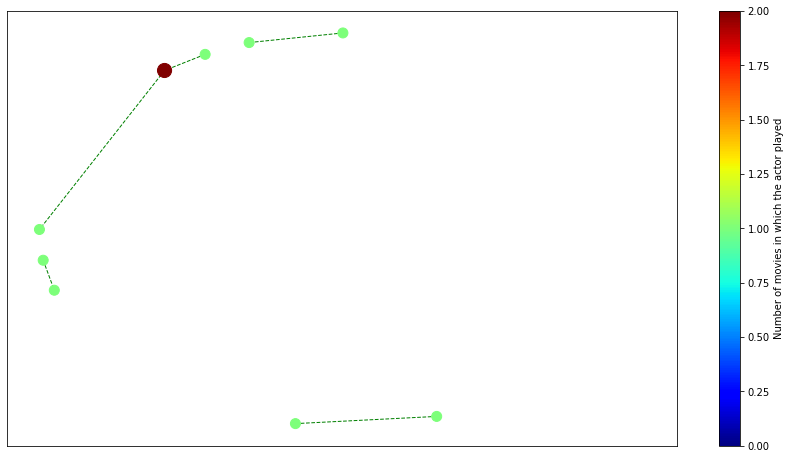

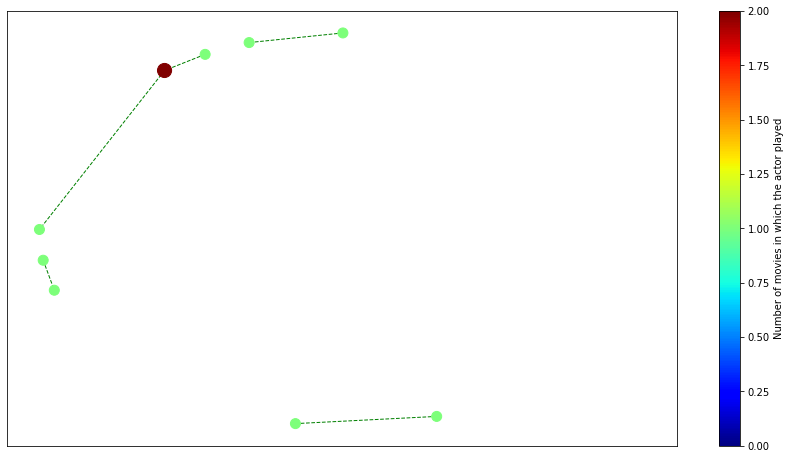

In [78]:
# CO-STARDOM NETWORK

movies = [movie[0] for movie in heapq.nlargest(10, sim_years.items(), key = lambda i: i[1])]
G = utils.add_nodes(movies)
G = utils.add_edges(G)
utils.draw_graph(G)